# Background fit 

### Non-Resonant background 

In [7]:
import uproot
import awkward as ak
from vector import Array as awk
import numpy as np

# Path to the ROOT file and tr/ee
file_path_signal = "../../../output_root/v2_production/backgrounds/GJetPt20to40.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)


# Compute diphoton mass from its Lorentz vector
diphoton_mass = diphoton_.mass


diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Convert extracted variabless to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
# dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dijet_mass - 125)

## Updated bins and the mass windows

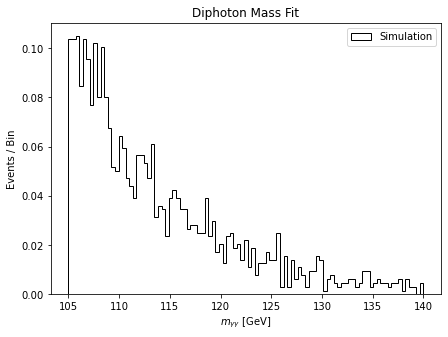

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk


# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
# plt.plot(x_fit, y_fit, color="blue", label="Gaussian Fit")
# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit")
plt.show()

perfoming exponential fit on the mass ranges of 105-140 Gev, reason 
for choosing the above range because to avoid the turn-on in the backgrounds.
### Exponentail fit


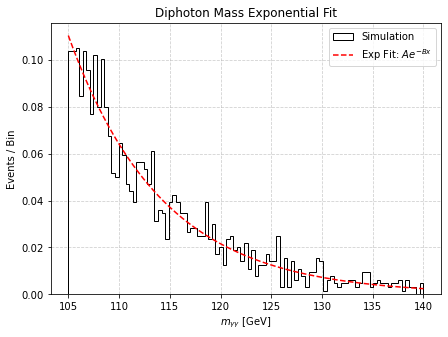

Fitted Parameters: A = 10059.090, B = 0.10877


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential function for fitting
def exp_fit(x, A, B):
    return A * np.exp(-B * x)

# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass_np, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# Fit histogram data to exponential function
params, covariance = curve_fit(exp_fit, bin_centers, hist, p0=[1, 0.01])

# Generate fitted curve
x_fit = np.linspace(105, 140, 500)
y_fit = exp_fit(x_fit, *params)

# Plot histogram and exponential fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass_np, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Exp Fit: $A e^{-Bx}$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Exponential Fit")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot

# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.pdf")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.png")
plt.show()
# Print fit parameters
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}")


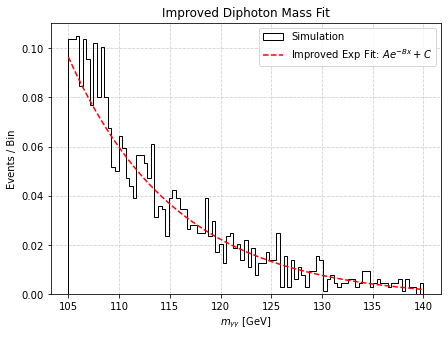

Fitted Parameters: A = 1850.630, B = 0.09376, C = -0.00166


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[1, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Plot histogram and improved fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass_np, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Improved Diphoton Mass Fit")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.pdf")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.png")
plt.show()
# Print improved fit parameters
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")


## Writing to ROOT

In [11]:
import ROOT
import numpy as np

# Open a new ROOT file to store the fitted signal
fout = ROOT.TFile("fit_shapes.root", "UPDATE")

# Define the histogram
hist_sig = ROOT.TH1F("GJetPt20to40", "Exponential Fit GJetPt40", len(bin_centers) - 1, bin_centers)

# Fill the histogram with the fitted values
for i in range(len(bin_centers)):
    hist_sig.SetBinContent(i + 1, y_fit[i])  # Use the Crystal Ball fit values

# Save the histogram to the ROOT file
hist_sig.Write()
fout.Close()


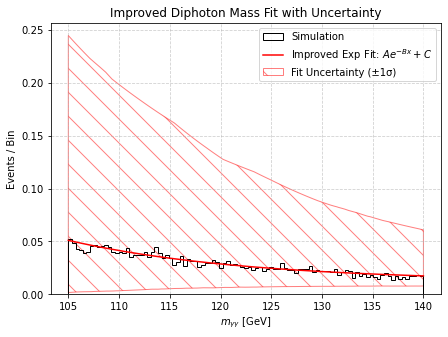

Fitted Parameters: A = 15.063 ± 24.855, B = 0.05675 ± 0.01608, C = 0.01215 ± 0.00438


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define histogram binning
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass_np, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# Define the fit range (focus on mid-range)
fit_mask = (bin_centers > 110) & (bin_centers < 135)

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[1, 0.01, 0])

# Extract fit parameters and uncertainties
A_fit, B_fit, C_fit = params
A_err, B_err, C_err = np.sqrt(np.diag(covariance))  # Uncertainties

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, A_fit, B_fit, C_fit)

# Generate uncertainty bands using Monte Carlo sampling
num_samples = 1000
y_samples = np.array([exp_fit(x_fit, 
                              np.random.normal(A_fit, A_err), 
                              np.random.normal(B_fit, B_err), 
                              np.random.normal(C_fit, C_err)) 
                      for _ in range(num_samples)])

y_err_up = np.percentile(y_samples, 84, axis=0)  # +1σ (Upper bound)
y_err_down = np.percentile(y_samples, 16, axis=0)  # -1σ (Lower bound)

# Plot histogram
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass_np, bins=bins, density=True, histtype="step", color="black", label="Simulation")

# Plot fit and hatched uncertainty bands
plt.plot(x_fit, y_fit, color="red", linestyle="-", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Apply hatched pattern to uncertainty band
plt.fill_between(x_fit, y_err_down, y_err_up, 
                 facecolor="none", edgecolor="red", hatch="\\", alpha=0.5, label="Fit Uncertainty (±1σ)")

# Labels and CMS-style formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Improved Diphoton Mass Fit with Uncertainty")
plt.grid(True, linestyle="--", alpha=0.6)

# Save the plot
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/nonres_fitting_GJet40_with_hatch_uncertainty.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/nonres_fitting_GJet40_with_hatch_uncertainty.png")
plt.show()

# Print fit parameters with uncertainties
print(f"Fitted Parameters: A = {A_fit:.3f} ± {A_err:.3f}, B = {B_fit:.5f} ± {B_err:.5f}, C = {C_fit:.5f} ± {C_err:.5f}")


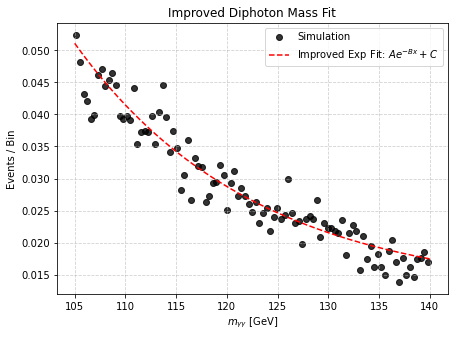

Fitted Parameters: A = 15.063, B = 0.05675, C = 0.01215


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[1, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Plot simulation data as circles
plt.figure(figsize=(7, 5))
plt.scatter(bin_centers, hist, color="black", marker='o', label="Simulation", alpha=0.8)

# Plot the fitted curve
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Improved Diphoton Mass Fit")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/Scatter_fitting_GJet40.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/Scatter_fitting_GJet40.png")
plt.show()
# Print improved fit parameters
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")


## Fitting backgrounds

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk

# Load the ROOT file and extract diphoton mass
# file_path_signal = "/mnt/data/GJetPt40.root"  # Update this if needed
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"



# Define Gaussian fit function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the histogram data with a Gaussian
popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[0.01, 125, 10])

# Generate smooth Gaussian curve
x_fit = np.linspace(105, 140, 100)
y_fit = gaussian(x_fit, *popt)

# Calculate FWHM
sigma = popt[2]
mu = popt[1]
fwhm_low, fwhm_high = mu - sigma * np.sqrt(2 * np.log(2)), mu + sigma * np.sqrt(2 * np.log(2))

# Plot
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="blue", label="Gaussian Fit")
plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit")
plt.show()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
# Adjusted initial parameters for better fit
initial_guess = [0.01, 125, 1.5, 1.2, 3.0, 1.5, 3.0]  

# Fit using the adjusted parameters
popt_dscb, pcov_dscb = curve_fit(dscb_vectorized, bin_centers, hist, p0=initial_guess, maxfev=5000)

# Compute parameter errors (square root of diagonal elements of covariance matrix)
errors_dscb = np.sqrt(np.diag(pcov_dscb))

# Generate DSCB curve
y_fit_dscb = dscb_vectorized(x_fit, *popt_dscb)


In [ ]:
from scipy.stats import norm

# Fit Gaussian
popt_gauss, _ = curve_fit(lambda x, A, mu, sigma: A * norm.pdf(x, mu, sigma), bin_centers, hist, 
                          p0=[0.01, 125, 2.0])

# Generate Gaussian curve
y_fit_gauss = popt_gauss[0] * norm.pdf(x_fit, popt_gauss[1], popt_gauss[2])


In [ ]:
def chi_square(y_obs, y_exp, errors):
    return np.sum(((y_obs - y_exp) / errors) ** 2) / (len(y_obs) - len(popt_dscb))

# Estimate histogram uncertainties (Poisson errors)
errors_hist = np.sqrt(hist + 1e-6)  # Adding small value to avoid division by zero

# Compute Chi-square
chi2_dscb = chi_square(hist, dscb_vectorized(bin_centers, *popt_dscb), errors_hist)
chi2_gauss = chi_square(hist, popt_gauss[0] * norm.pdf(bin_centers, popt_gauss[1], popt_gauss[2]), errors_hist)

print(f"Reduced χ² (DSCB) = {chi2_dscb:.3f}")
print(f"Reduced χ² (Gaussian) = {chi2_gauss:.3f}")


In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit_dscb, color="red", label="Double-Sided Crystal Ball Fit")
# plt.plot(x_fit, y_fit_gauss, color="blue", linestyle="dashed", label="Gaussian Fit")

# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit: DSCB vs Gaussian")
plt.show()


### complete code 

In [ ]:
import uproot
import awkward as ak
from vector import Array as awk
import numpy as np

# Path to the ROOT file and tree
file_path_signal = "../../../output_root/v2_production/backgrounds/GJetPt40.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)

In [ ]:
# Compute diphoton mass from its Lorentz vector
diphoton_mass = diphoton_.mass


diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Convert extracted variabless to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
# dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dijet_mass - 125)

# Adjusted initial parameters for better fit
initial_guess = [0.01, 125, 1.5, 1.2, 3.0, 1.5, 3.0]  

# Fit using the adjusted parameters
popt_dscb, pcov_dscb = curve_fit(dscb_vectorized, bin_centers, hist, p0=initial_guess, maxfev=5000)

# Compute parameter errors (square root of diagonal elements of covariance matrix)
errors_dscb = np.sqrt(np.diag(pcov_dscb))

# Generate DSCB curve
y_fit_dscb = dscb_vectorized(x_fit, *popt_dscb)

from scipy.stats import norm

# Fit Gaussian
popt_gauss, _ = curve_fit(lambda x, A, mu, sigma: A * norm.pdf(x, mu, sigma), bin_centers, hist, 
                          p0=[0.01, 125, 2.0])

# Generate Gaussian curve
y_fit_gauss = popt_gauss[0] * norm.pdf(x_fit, popt_gauss[1], popt_gauss[2])

def chi_square(y_obs, y_exp, errors):
    return np.sum(((y_obs - y_exp) / errors) ** 2) / (len(y_obs) - len(popt_dscb))

# Estimate histogram uncertainties (Poisson errors)
errors_hist = np.sqrt(hist + 1e-6)  # Adding small value to avoid division by zero

# Compute Chi-square
chi2_dscb = chi_square(hist, dscb_vectorized(bin_centers, *popt_dscb), errors_hist)
chi2_gauss = chi_square(hist, popt_gauss[0] * norm.pdf(bin_centers, popt_gauss[1], popt_gauss[2]), errors_hist)

print(f"Reduced χ² (DSCB) = {chi2_dscb:.3f}")
print(f"Reduced χ² (Gaussian) = {chi2_gauss:.3f}")

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit_dscb, color="red", label="Double-Sided Crystal Ball Fit")
# plt.plot(x_fit, y_fit_gauss, color="blue", linestyle="dashed", label="Gaussian Fit")

# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit: DSCB vs Gaussian")
plt.show()

In [ ]:
import uproot
import awkward as ak
from vector import Array as awk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mplhep as hep
from matplotlib.ticker import MaxNLocator

# Path to the ROOT file and tree
file_path_signal = "../../../output_root/v2_production/backgrounds/GJetPt40.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)

# Compute diphoton mass from its Lorentz vector
diphoton_mass = diphoton_.mass

diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Convert extracted variables to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dijet_mass - 125)

# Define the DSCB function (Double-Sided Crystal Ball)
def dscb(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    # Add small regularization terms to prevent invalid power-law operations
    epsilon = 1e-6  # Small number to avoid division by zero
    left = np.where(x < mu, A * (1 + np.maximum((x - mu) / alphaL, epsilon)) ** (-nL), 0)
    right = np.where(x >= mu, A * (1 + np.maximum((x - mu) / alphaR, epsilon)) ** (-nR), 0)
    gauss = A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return left + right + gauss

# Binning the diphoton mass
bins = np.linspace(0,180, 200)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Create histogram of the diphoton mass
hist, _ = np.histogram(diphoton_mass_np, bins=bins, density=True)

# Remove NaNs and Infs from the data
valid_indices = np.isfinite(hist) & np.isfinite(bin_centers)
hist = hist[valid_indices]
bin_centers = bin_centers[valid_indices]

# Initial guess for DSCB fitting
# initial_guess_dscb = [1, 125, 2.0, 1.5, 3.0, 1.5, 3.0]
initial_guess_dscb = [0.01, 125, 1.5, 1.2, 3.0, 1.5, 3.0]  

# Bounds for the DSCB fit
lower_bounds = [0, 100, 0.5, 0.1, 0.1, 0.1, 0.1]
upper_bounds = [np.inf, 150, 5.0, 5.0, 10.0, 5.0, 10.0]

# Fit the histogram with DSCB
try:
    popt_dscb, pcov_dscb = curve_fit(dscb, bin_centers, 
                                     hist, p0=initial_guess_dscb, 
                                     bounds=(lower_bounds, upper_bounds),
                                     maxfev=5000)
    # Compute parameter errors (square root of diagonal elements of covariance matrix)
    errors_dscb = np.sqrt(np.diag(pcov_dscb))
    
    # Generate the fitted curve for DSCB
    x_fit = np.linspace(0, 180, 200)
    y_fit_dscb = dscb(x_fit, *popt_dscb)
    
    # Apply CMS style using mplhep
    hep.style.use("CMS")  # Using CMS style from mplhep
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.hist(diphoton_mass_np, bins=bins, density=True, histtype='step', color='black', label="Simulation", linewidth=2)

    # Plot the DSCB fit curve
    plt.plot(x_fit, y_fit_dscb, color='red', label='DSCB Fit', linewidth=2)

    # Customize the plot with a title, labels, and grid
    plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]", fontsize=20)
    plt.ylabel("Events / Bin", fontsize=20)
    plt.title("Diphoton Mass Fit: DSCB", fontsize=20)

    # Add a legend with a white background and some transparency
    plt.legend(loc='upper right', fontsize=16, frameon=True, framealpha=0.7, borderpad=1)

    # Adjust axis ticks for better readability
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Add gridlines and set grid style for clarity
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Show the plot
    plt.tight_layout()  # This adjusts the padding for better layout
    plt.show()

except Exception as e:
    print(f"An error occurred during the fitting: {e}")


### Resonant background

For resonant background, we consider all possible Higgs production mechanisms: gluon-gluon129
fusion (ggH), vector-boson fusion (VBFH), associated production with a vector boson (VH), top130
quarks (ttH), and b-quarks (bbH) where Higgs decays into two photons.131